# Start working on a standalone autoencoder class

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class PreConvBlock(nn.Module):
    def __init__(self, 
                 in_channels = 1, 
                 out_channels = 16, 
                 kernel = 3, 
                 stride=1, 
                 pool_size = 2,
                 use_batch_norm = False):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride for the convolutional layers.
        """
        super(PreConvBlock, self).__init__()
        
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, 
                      kernel_size=kernel, stride=stride, 
                      padding=(kernel - stride) // 2, 
                      bias= not use_batch_norm),
        ])
        if use_batch_norm:
            self.layers.append(nn.BatchNorm2d(out_channels))
        
        self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.MaxPool2d(kernel_size=pool_size))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
class ResidualBlock(nn.Module):
    def __init__(self, 
                 n_channels = 16, 
                 kernel = 3, 
                 stride = 1, 
                 use_batch_norm = False, 
                 downsample=None,
                 pool_size = 4,
                 n_layers = 3):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride for the convolutional layers.
            downsample (nn.Module, optional): Downsampling layer if input and output dimensions differ.
        """
        super(ResidualBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        for i_layer in range(n_layers):
            self.layers.append(nn.Conv2d(n_channels, n_channels, 
                                          kernel_size=kernel, stride=stride, 
                                          padding=(kernel - stride) // 2, 
                                          bias= not use_batch_norm))
            if use_batch_norm:
                self.layers.append(nn.BatchNorm2d(n_channels))
            if i_layer!=(n_layers - 1):
                self.layers.append(nn.ReLU(inplace=True))
        
        self.downsample = downsample  # Optional downsampling layer
        self.post_residual_layers = nn.ModuleList([nn.ReLU(inplace=True)])
        if pool_size is not None:
            self.post_residual_layers.append(nn.MaxPool2d(kernel_size=pool_size))
    
    def forward(self, x):
        identity = x

        # Pass through the layers in the ModuleList
        for layer in self.layers:
            x = layer(x)

        # Apply downsampling to the identity if necessary
        if self.downsample:
            identity = self.downsample(identity)

        # Add the residual connection
        x += identity
        for layer in self.post_residual_layers:
            x = layer(x)

        return x
    
class Encoder(nn.Module):

    def __init__(self, 
                 configs):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride for the convolutional layers.
        """
        super(Encoder, self).__init__()
        
        self.configs = configs

        self.residual_layers = nn.ModuleList()

        for i_blocks in range(configs['num_blocks']):
            self.residual_layers.append(PreConvBlock(configs['in_channels_%d'%i_blocks],
                                            configs['out_channels_%d'%i_blocks],
                                            configs['kernel_preconv'],
                                            configs['stride_preconv'],
                                            configs['pool_size_preconv_%d'%i_blocks],
                                            configs['use_batch_norm_preconv']))
            self.residual_layers.append(ResidualBlock(configs['out_channels_%d'%i_blocks],
                                             configs['kernel_residual'],
                                             configs['stride_residual'],
                                             configs['use_batch_norm_residual'],
                                             pool_size=configs['pool_size_residual_%d'%i_blocks],
                                             n_layers=configs['n_layers_residual']))
            
        self.linear_layers = nn.ModuleList([nn.Linear(configs['out_conv'], configs['out_linear'], bias = not configs['use_batch_norm_linear']),])
        if configs['use_batch_norm_linear']:
            self.linear_layers.append(nn.BatchNorm1d(configs['out_linear']))
        self.linear_layers.append(nn.ReLU(inplace=True))
        self.linear_layers.append(nn.Linear(configs['out_linear'], configs['embed_size']))

    def forward(self, x):
        bs, seq_length, c, h ,w = x.size()
        
        x = x.view(bs*seq_length, c, h, w)
        for layer in self.residual_layers:
            x = layer(x)
        
        x = x.view(bs*seq_length, -1)
        for layer in self.linear_layers:
            x = layer(x)
        
        x = x.view(bs, seq_length, -1)
        return x

In [3]:
class SingleSessionDecoder(nn.Module):
    def __init__(self, configs):
        super(SingleSessionDecoder, self).__init__()
        self.configs = configs
        self.linear_layer = nn.Linear(configs['embed_size'], configs['image_height']*configs['image_width'])

    def forward(self, x):
        bs, seq_length, _ = x.size()
        x = self.linear_layer(x)
        x = x.view(bs, seq_length, 1, self.configs['image_height'], self.configs['image_width'])
        return x

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, configs):
        super(AutoEncoder, self).__init__()
        self.configs = configs
        self.encoder = Encoder(configs)
        self.decoder = SingleSessionDecoder(configs)
    
    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z

In [5]:
configs = {
    'num_blocks': 2,
    'in_channels_0': 1,
    'out_channels_0': 16,
    'in_channels_1': 16,
    'out_channels_1': 32,
    'kernel_preconv': 3,
    'stride_preconv': 1,
    'pool_size_preconv_0': 2,
    'pool_size_preconv_1': 4,
    'use_batch_norm_preconv': False,
    'kernel_residual': 3,
    'stride_residual': 1,
    'use_batch_norm_residual': False,
    'pool_size_residual_0': None,
    'pool_size_residual_1': 4,
    'n_layers_residual': 3,
    'out_conv': 288,
    'out_linear': 128,
    'embed_size': 16,
    'use_batch_norm_linear': False,
    'image_height': 120,
    'image_width': 112
}

In [6]:
AE = AutoEncoder(configs)

In [7]:
AE

AutoEncoder(
  (encoder): Encoder(
    (residual_layers): ModuleList(
      (0): PreConvBlock(
        (layers): ModuleList(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (1): ResidualBlock(
        (layers): ModuleList(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
          (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (post_residual_layers): ModuleList(
          (0): ReLU(inplace=True)
        )
      )
      (2): PreConvBlock(
        (layers): ModuleList(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          

In [8]:
import cv2

def process_image(
    image,
    target_shape,
    *,
    transpose=False,
    remove_info = None,
    toy_mode=False
    ):
    """Given an image, process it and return the array."""
    # Load the image.
    h, w, c = target_shape
    x = cv2.imread(image,0)
    # x = mpimg.imread(image)[:,:,0]
    if x is None:
        print(image)
    if transpose:
        x = np.transpose(x,(1,0))
    h_origin, w_origin = x.shape
    if remove_info is not None:
        coord, mean, mode = remove_info['coord'], remove_info['mean'], remove_info['mode']
        if mode == 'crop':
            x = x[int(coord[0]/h*h_origin+0.5):]
        elif mode == 'block':
            x[:int(coord[0]/h*h_origin+0.5)] = x.max()
            assert toy_mode
        else:
            assert False
    if (x.shape[0] != h) or (x.shape[1] != w):
        x = cv2.resize(x,(w,h))
    x = (x / 255.).astype(np.float32)
    return x

In [77]:
img = process_image(image= '/data5/zwang71/MiceBehavior/data/SC/frames/side/SC065/20210506/SC-SC065-20210506-19/SC-SC065-20210506-19-side-01094.jpg',
              target_shape=(120,112,1),
              remove_info= {'mode': 'crop', 'coord': [26,20],'mean': None },)

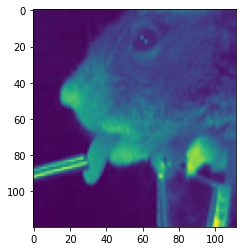

In [78]:
plt.imshow(img)

(5, 120, 112)


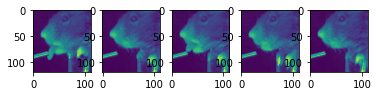

In [105]:
inds = ['01094','00195','01200','01120','01900']
example_images = []
for i,indstr in enumerate(inds):
    img = process_image(image= '/data5/zwang71/MiceBehavior/data/SC/frames/side/SC065/20210506/SC-SC065-20210506-19/SC-SC065-20210506-19-side-%s.jpg'%indstr,
              target_shape=(120,112,1),
              remove_info= {'mode': 'crop', 'coord': [26,20],'mean': None },)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    example_images.append(img)

example_images = np.array(example_images)
print(example_images.shape)
np.save('/mnt/fs6/zwang71/BehaviorVideo/rewrite_autoencoder/example_images.npy',example_images)

    

In [9]:
example_images = np.load('./example_images.npy')

In [10]:
AE = AutoEncoder(configs)
optimizer = torch.optim.Adam(AE.parameters(), lr=1e-3)

loss_fn = nn.MSELoss()

n_epochs = 1000

for epoch in range(n_epochs):
    optimizer.zero_grad()
    x_hat, z = AE.forward(torch.tensor(example_images).float().view(5,1,1,120,112))
    loss = loss_fn(x_hat.squeeze(), torch.tensor(example_images).float())
    loss.backward()
    optimizer.step()
    if epoch%100 == 99: print(epoch, loss.item())

99 0.005737863481044769
199 0.004701429046690464
299 0.004673847462981939
399 0.004424507729709148
499 0.003163414541631937
599 0.0021676139440387487
699 0.0018437624676153064
799 0.0015401412965729833
899 0.001178801991045475
999 0.0008210404776036739


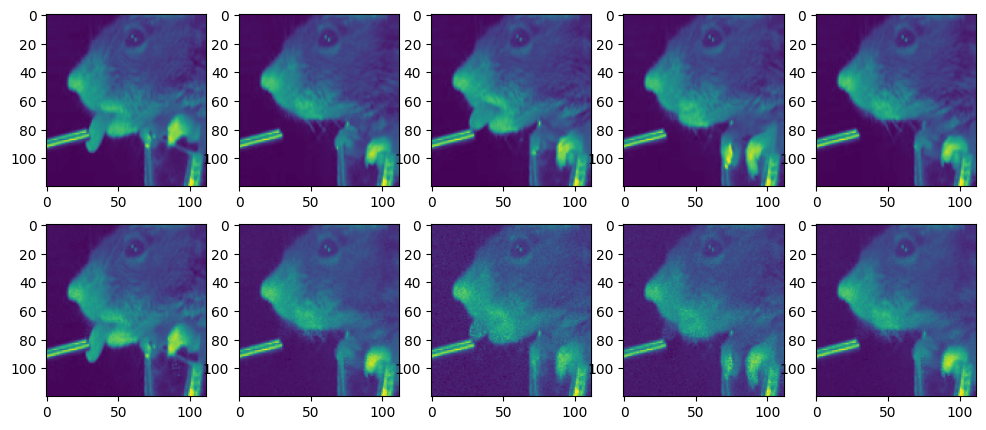

In [12]:
with torch.no_grad():
    img_hat, z = AE.forward(torch.tensor(example_images).float().view(5,1,1,120,112))
plt.subplots(2,5,figsize=(12,5))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(example_images[i])
    plt.subplot(2,5,i+6)
    plt.imshow(img_hat.squeeze().detach().numpy()[i])

# Data loading

## On CCN serer

In [13]:
import cv2
import os

In [14]:
def transform_image(image_path, target_shape = (120,112,1), crop_info = {'h_coord': 26}):
    img = cv2.imread(image_path,0)
    h_origin, w_origin = img.shape
    h, w, c = target_shape
    img = img[int(crop_info['h_coord'] / h * h_origin + 0.5):,:]
    img = cv2.resize(img,(w,h))
    img = (img / 255.).astype(np.float32)
    return img

In [17]:
base_folder = '/data5/zwang71/MiceBehavior/data/SC/frames/side/SC065/20210506/'
trial_folders = np.sort(os.listdir(base_folder))
frame_dict = {folder: os.listdir(os.path.join(base_folder,folder)) for folder in trial_folders}

np.sum([len(frame_dict[folder]) for folder in trial_folders])

785086

In [23]:
from torch.utils.data import Dataset, DataLoader

In [22]:
class SessionFramesDataset(Dataset):
    def __init__(self, base_folder, crop_info = {'h_coord': 26}):
        self.base_folder = base_folder
        self.crop_info = crop_info
        self.frame_list = []

        self.trial_folders = np.sort(os.listdir(base_folder))
        self.frame_dict = {folder: np.sort(os.listdir(os.path.join(base_folder,folder))) for folder in self.trial_folders}
        self.trial_lengths = [len(self.frame_dict[folder]) for folder in self.trial_folders]
        self.cumsum_n_trials = np.cumsum(self.trial_lengths)

        
    
    def __len__(self):
        return np.sum(self.trial_lengths)
    
    def __getitem__(self, idx):
        trial_idx = np.argmax(self.cumsum_n_trials > idx)
        frame_idx = idx - trial_idx
        
        img = transform_image(
            image_path = os.path.join(
                self.base_folder,
                self.trial_folders[trial_idx],
                self.frame_dict[self.trial_folders[trial_idx]][trial_idx]), 
            crop_info = self.crop_info)
        return img

In [23]:
dataset = SessionFramesDataset(base_folder)

In [24]:
len(dataset)

785086

In [24]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched.size())
    plt.subplots(8,8,figsize=(12,12))
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.imshow(sample_batched[i])
    break

In [ ]:
import time
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=10)

start_time = time.time()
for i, batch in enumerate(dataloader):
    if i >= 100:  # Process 100 batches as a sample
        break
end_time = time.time()

time_per_batch = (end_time - start_time) / 100
images_per_second = 64 / time_per_batch
estimated_total_time = (700000 / images_per_second) / 60  # Minutes
print(f"Estimated time to load 700k images: {estimated_total_time:.2f} minutes")

### Try out training the autoencoder on the real dataset on CCN

In [42]:
AE = AutoEncoder(configs)
optimizer = torch.optim.Adam(AE.parameters(), lr=1e-3)
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=10)
loss_fn = nn.MSELoss()

n_epochs = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
AE.to(device)

for epoch in range(n_epochs):
    for i_batch, sample_batched in enumerate(dataloader):
        if sample_batched.size()[0] != batch_size:
            continue
        optimizer.zero_grad()
        x_hat, z = AE.forward(sample_batched.to(device).view(batch_size,1,1,120,112))
        loss = loss_fn(x_hat.squeeze(), sample_batched.to(device).float())
        loss.backward()
        optimizer.step()
        if i_batch%1000 == 999: print(epoch, i_batch, loss.item())

0 999 0.00273349997587502
0 1999 0.0016523812664672732
0 2999 0.0015420359559357166
1 999 0.0011556062381714582
1 1999 0.0010874358704313636
1 2999 0.001019478077068925
2 999 0.0007991332677192986
2 1999 0.0007620056858286262
2 2999 0.0006916700513102114


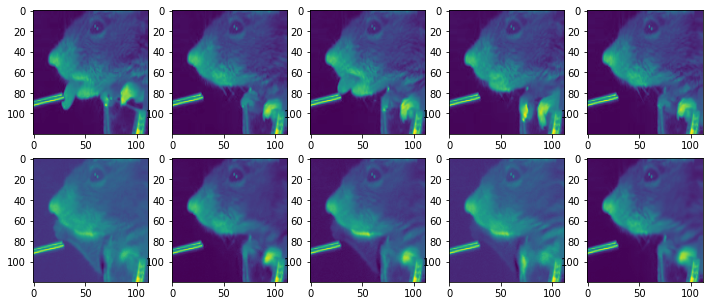

In [45]:
with torch.no_grad():
    img_hat, z = AE.forward(torch.tensor(example_images).float().view(5,1,1,120,112).to(device))

plt.subplots(2,5,figsize=(12,5))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(example_images[i])
    plt.subplot(2,5,i+6)
    plt.imshow(img_hat.squeeze().cpu().detach().numpy()[i])

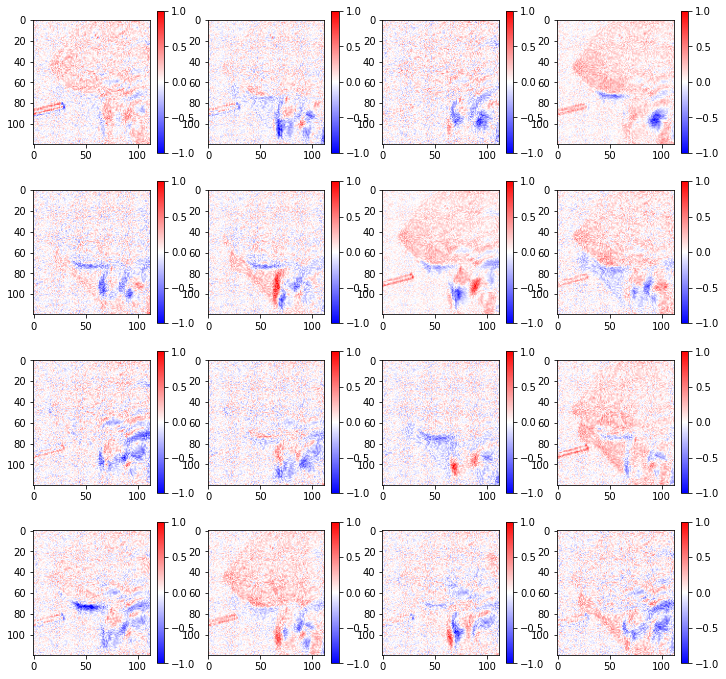

In [49]:
latents = []
for i in range(16):
    input_z = torch.zeros(1,1,16).to(device)
    input_z[0,0,i] = 1
    latent = AE.decoder(input_z).squeeze().cpu().detach().numpy()
    latents.append(latent)

plt.subplots(4,4,figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(latents[i], cmap = 'bwr', vmin = -1, vmax = 1)
    plt.colorbar()

## Load images from .tar file direcly

In [11]:
import os
import tarfile
import numpy as np
import cv2
import io
from torch.utils.data import Dataset

def transform_image_from_tar(tar_obj, member_name, target_shape=(120, 112, 1), crop_info={'h_coord': 26}):
    """
    Extracts an image from the tar archive and applies the same transforms as before.
    """
    # Extract the file-like object from the tar
    fileobj = tar_obj.extractfile(member_name)
    if fileobj is None:
        raise ValueError(f"Could not extract {member_name}")
    # Read the raw bytes and convert them into a numpy array
    file_bytes = fileobj.read()
    arr = np.frombuffer(file_bytes, np.uint8)
    # Decode the image (read in grayscale mode)
    img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)
    
    h_origin, w_origin = img.shape
    h, w, c = target_shape
    # Crop the image based on the provided crop_info
    img = img[int(crop_info['h_coord'] / h * h_origin + 0.5):, :]
    # Resize and normalize the image
    img = cv2.resize(img, (w, h))
    img = (img / 255.).astype(np.float32)
    return img

class SessionFramesDataset(Dataset):
    def __init__(self, tar_path, crop_info={'h_coord': 26}):
        """
        Opens the tar archive and builds an index of trial folders and image file names.
        Assumes that the archive has a folder structure like:
            trial_folder_1/
                img1.jpg
                img2.jpg
            trial_folder_2/
                img1.jpg
                ...
        """
        self.tar_path = tar_path
        self.crop_info = crop_info

        # Open the tar archive in read mode (gzip compressed)
        self.tar = tarfile.open(self.tar_path, "r:gz")
        # List all members that are files with image extensions
        self.members = [m for m in self.tar.getmembers() 
                        if m.isfile() and m.name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        # Build a dictionary grouping members by the first-level directory (trial folder)
        self.frame_dict = {}
        for member in self.members:
            # Assumes the first part of the path is the trial folder name.
            folder = member.name.split('/')[0]
            self.frame_dict.setdefault(folder, []).append(member.name)
            
        # Sort the folders and the image file names in each folder.
        self.trial_folders = sorted(self.frame_dict.keys())
        for folder in self.trial_folders:
            self.frame_dict[folder] = sorted(self.frame_dict[folder])
            
        # Compute the number of frames per trial and a cumulative sum for indexing
        self.trial_lengths = [len(self.frame_dict[folder]) for folder in self.trial_folders]
        self.cumsum_n_trials = np.cumsum(self.trial_lengths)
        
    def __len__(self):
        return int(np.sum(self.trial_lengths))
    
    def __getitem__(self, idx):
        # Identify the trial folder for this global index
        trial_idx = np.argmax(self.cumsum_n_trials > idx)
        # Compute the frame index within the selected trial folder
        if trial_idx == 0:
            frame_idx = idx
        else:
            frame_idx = idx - self.cumsum_n_trials[trial_idx - 1]
            
        member_name = self.frame_dict[self.trial_folders[trial_idx]][frame_idx]
        img = transform_image_from_tar(self.tar, member_name, crop_info=self.crop_info)
        return img


In [12]:
tar_path = '/home/kurgyis/Research/MapVideoAnalysis/data/raw_frames/SC065_20210506_frames.tar'
dataset = SessionFramesDataset(tar_path)

In [13]:
img = dataset[100]

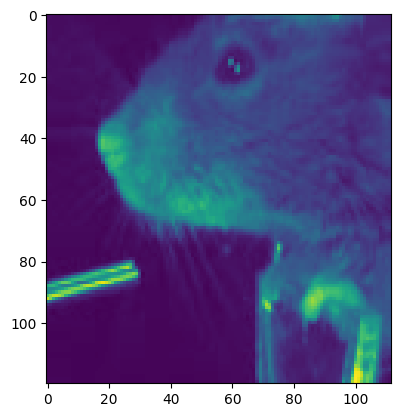

In [14]:
plt.imshow(img)

This is extremely slow. Have to use WebDataset to load the images.

### Load .tar using WebDataset


In [15]:
import webdataset as wds
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.transforms.functional as F
import time

In [16]:
class CustomCropResize:
    def __init__(self, target_shape=(120, 112, 1), crop_info={'h_coord': 26}):
        """
        Args:
            target_shape: (height, width, channels)
            crop_info: dict with cropping parameters. For example, 
                       crop_info['h_coord'] determines the crop start as:
                       int(crop_info['h_coord'] / target_height * original_height + 0.5)
        """
        self.target_shape = target_shape
        self.crop_info = crop_info

    def __call__(self, img):
        # Ensure the image is in grayscale
        if img.mode != 'L':
            img = img.convert('L')
        # Get target height and width from target_shape
        h_target, w_target, _ = self.target_shape
        # Get original dimensions (PIL gives (width, height))
        original_width, original_height = img.size
        # Compute the vertical crop coordinate, analogous to your cv2 code
        crop_y = int(self.crop_info['h_coord'] / h_target * original_height + 0.5)
        # Crop the image: from crop_y to bottom, full width
        img = F.crop(img, crop_y, 0, original_height - crop_y, original_width)
        # Resize the image to the target dimensions.
        # F.resize expects size as (height, width).
        img = F.resize(img, (h_target, w_target))
        # Convert the image to a tensor (this scales pixel values to [0, 1])
        img = F.to_tensor(img)
        return img


In [17]:
# Create an instance of your custom transform
custom_transform = CustomCropResize(target_shape=(120, 112, 1), crop_info={'h_coord': 26})

dataset = wds.WebDataset(
    "/home/kurgyis/Research/MapVideoAnalysis/data/raw_frames/SC065_20210506_frames.tar"
).select(lambda sample: "jpg" in sample) \
  .shuffle(1000).decode('pil') \
  .to_tuple("jpg") \
  .map(lambda x: custom_transform(x[0]))

dataloader = DataLoader(dataset, batch_size=64, num_workers=1)

# Iterate over batches for example timing

start_time = time.time()
for i, batch in enumerate(dataloader):
    if i >= 100:
        break
end_time = time.time()
print(f"Images per second: {64 / ((end_time - start_time) / 100):.2f}")
estimated_total_time = (700000 / images_per_second) / 60  # Minutes
print(f"Estimated time to load 700k images: {estimated_total_time:.2f} minutes")

/home/kurgyis/Research/MapVideoAnalysis/local_venv/lib/python3.12/site-packages/webdataset/compat.py:389: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn(


Images per second: 2369.57


NameError: name 'images_per_second' is not defined

### Try a mini training loop on the full dataset

In [63]:
AE = AutoEncoder(configs)
optimizer = torch.optim.Adam(AE.parameters(), lr=1e-3)
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=1)
loss_fn = nn.MSELoss()

n_epochs = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
AE.to(device)

for epoch in range(n_epochs):
    for i_batch, sample_batched in enumerate(dataloader):
        if sample_batched.size()[0] != batch_size:
            continue
        optimizer.zero_grad()
        x_hat, z = AE.forward(sample_batched.to(device).view(batch_size,1,1,120,112))
        loss = loss_fn(x_hat.squeeze(), sample_batched.to(device).float())
        loss.backward()
        optimizer.step()
        if i_batch%1000 == 999: print(epoch, i_batch, loss.item())

/home/kurgyis/Research/MapVideoAnalysis/local_venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([256, 1, 120, 112])) that is different to the input size (torch.Size([256, 120, 112])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 999 0.0037042254116386175
0 1999 0.005190286785364151


KeyboardInterrupt: 

Much slower than running on CCN. Maybe will try to speed it up.

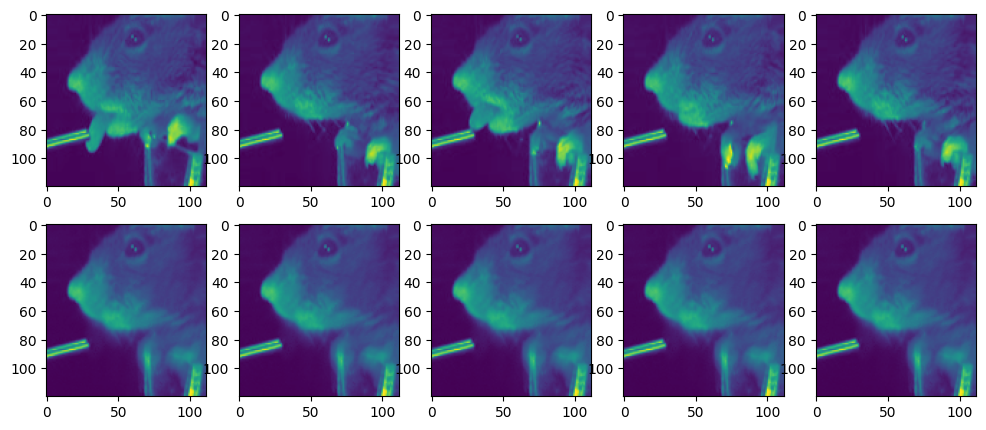

In [64]:
with torch.no_grad():
    img_hat, z = AE.forward(torch.tensor(example_images).float().view(5,1,1,120,112).to(device))

plt.subplots(2,5,figsize=(12,5))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(example_images[i])
    plt.subplot(2,5,i+6)
    plt.imshow(img_hat.squeeze().cpu().detach().numpy()[i])

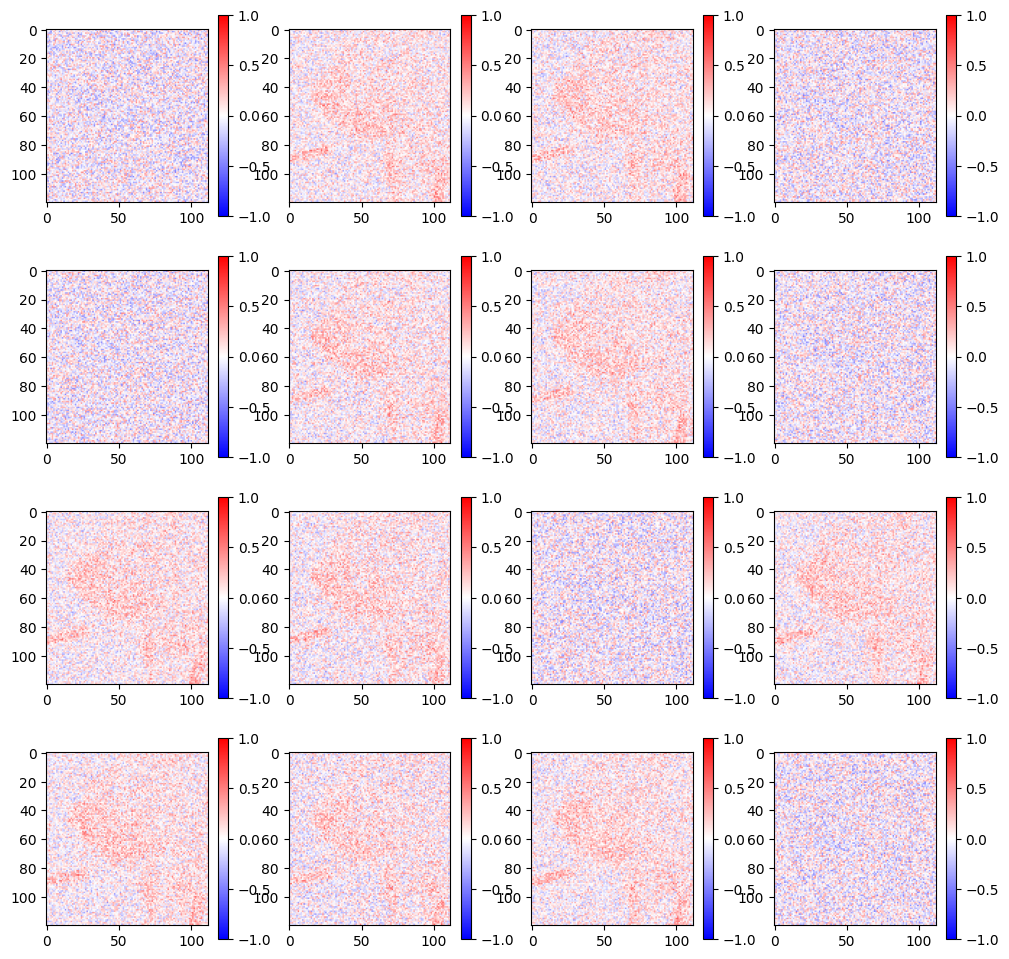

In [65]:
latents = []
for i in range(16):
    input_z = torch.zeros(1,1,16).to(device)
    input_z[0,0,i] = 1
    latent = AE.decoder(input_z).squeeze().cpu().detach().numpy()
    latents.append(latent)

plt.subplots(4,4,figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(latents[i], cmap = 'bwr', vmin = -1, vmax = 1)
    plt.colorbar()